Paper: "How to make hand hygiene interventions more attractive to nurses: A discrete choice experiment"

Author(s): Qian Zhao, Miles M. Yang, Yu-Ying Huang, and Wenlin Chen.

Year: 2018

Model(s): Multinomial Logit

Main findings: \_\_\_\_

# Import needed libraries

In [1]:
import sys
from collections import OrderedDict

import scipy.stats

import numpy as np
import pandas as pd

import seaborn as sbn
import matplotlib.pyplot as plt

from statsmodels.formula.api import logit

sys.path.insert(0, '/Users/timothyb0912/Documents/pylogit/')
import pylogit as pl

sys.path.insert(0, '../../src/')
from visualization import predictive_viz as viz

%matplotlib inline

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Import data

In [2]:
data_path =\
    '../../data/raw/zhao_2018/zhao_2018_data.dta'
df = (pd.read_stata(data_path)
        .sort_values(['personid', 'choicesetseq', 'alt']))

# Look at data

In [3]:
df.shape

(3200, 22)

In [4]:
df.head().T

,44,90,124,165,222
groupid,1,1,2,2,3
alt,1,2,1,2,1
asc,1,0,1,0,1
personid,1,1,1,1,1
choicesetseq,1,1,2,2,3
version,1,1,1,1,1
choice,1,0,0,1,0
hcw,1,1,1,1,1
age,4,4,4,4,4
workyr,5,5,5,5,5


In [5]:
set(df.columns.tolist())

{'_merge',
 'advantage',
 'age',
 'alt',
 'asc',
 'choice',
 'choiceset',
 'choicesetseq',
 'compatibility',
 'edulevel',
 'gender',
 'groupid',
 'hcw',
 'hospital',
 'moment',
 'observability',
 'personid',
 'place',
 'simplicity',
 'trialability',
 'version',
 'workyr'}

In [6]:
# How many individuals are in the dataset?
df.personid.unique().size

200

In [7]:
# How many choice sets per person?
df.choicesetseq.unique().size

8

# Clean data

In [8]:
# Initialize the clean datafram
clean_df = df.copy()

# Convert the columns of explanatory variables to dummy variables
# for col in ['advantage', 'compatibility', 'simplicity',
#             'trialability', 'observability']:
#     clean_df[col] = clean_df[col].map({1: 1, -1: 0})


In [9]:
# Look at the shape of clean_df
print('clean_df.shape == {}'.format(clean_df.shape))

# Look at some records in clean_df
clean_df.head(6).T


clean_df.shape == (3200, 22)


,44,90,124,165,222,267
groupid,1,1,2,2,3,3
alt,1,2,1,2,1,2
asc,1,0,1,0,1,0
personid,1,1,1,1,1,1
choicesetseq,1,1,2,2,3,3
version,1,1,1,1,1,1
choice,1,0,0,1,0,1
hcw,1,1,1,1,1,1
age,4,4,4,4,4,4
workyr,5,5,5,5,5,5


# Compute needed transformations / derived features

# Define the model specification and parameter names

In [10]:
explanatory_vars =\
    ['advantage',
     'compatibility',
     'simplicity',
     'trialability',
     'observability',
     'moment',
    ]

display_names = [x.upper() for x in explanatory_vars]

missing_vars =\
    [x for x in explanatory_vars if x not in clean_df.columns]
if len(missing_vars) > 0:
    msg = 'These explanatory variables are not in the data file:'
    raise ValueError(msg + '\n{}'.format(missing_vars))


# Populate the specification and name dictionaries
class SpecInfo(object):
    def __init__(self,
                 variable_list,
                 display_names):
        self.variable_list = variable_list
        self.name_list = display_names
        self.spec_dict = OrderedDict()
        self.name_dict = OrderedDict()
        
        self.populate_spec_and_name_dicts()
        return None
        
    def populate_spec_and_name_dicts(self):
        num_vars = len(self.variable_list)
        for pos in range(num_vars):
            current_column = self.variable_list[pos]
            self.spec_dict[current_column] = 'all_same'
            self.name_dict[current_column] = self.name_list[pos]
        return None

base_model_info = SpecInfo(explanatory_vars, display_names)

# Set model parameters

In [11]:
# This column denotes whether the row's alternative was chosen
choice_col = 'choice'
# This column denotes the alternative corresponding to the row
alt_id_col = 'alt'
# This column denotes the id of the row's unique choice situation
obs_id_col = 'groupid'

In [12]:
# Give names to the alternatives
alt_id_reverse_map = {1: '1', 2:'2'}

# Create the model object(s)

In [13]:
model_obj =\
    pl.create_choice_model(
        data=clean_df,
        alt_id_col=alt_id_col,
        obs_id_col=obs_id_col,
        choice_col=choice_col,
        specification=base_model_info.spec_dict,
        model_type='MNL',
        names=base_model_info.name_dict)

# Estimate and view the model

In [14]:
model_obj.fit_mle(np.zeros(len(display_names)))
model_obj.get_statsmodels_summary()

Log-likelihood at zero: -1,109.0355
Initial Log-likelihood: -1,109.0355
Estimation Time for Point Estimation: 0.02 seconds.
Final log-likelihood: -1,023.7108


/Users/timothyb0912/anaconda/lib/python2.7/site-packages/scipy/optimize/_minimize.py:507: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                1,600
Model:             Multinomial Logit Model   Df Residuals:                    1,594
Method:                                MLE   Df Model:                            6
Date:                     Sat, 02 Feb 2019   Pseudo R-squ.:                   0.077
Time:                             18:35:38   Pseudo R-bar-squ.:               0.072
AIC:                             2,059.422   Log-Likelihood:             -1,023.711
BIC:                             2,091.688   LL-Null:                    -1,109.035
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ADVANTAGE         0.1414      0.028      5.001      0.000       0.086       0.197
COMPATIBILITY     0.1885      0.027      6.871      0.000       0.135       0.242
SIMPLICITY        0.1086      0.027      3.969      0.000       0.055       0.162
TRIALABILITY      0.1987      0.027      7.250      0.000       0.145       0.252
OBSERVABILITY     0.1803      0.029      6.311      0.000       0.124       0.236
MOMENT           -0.0481      0.064     -0.750      0.453      -0.174       0.078
=================================================================================
"""

# Set checking parameters

In [15]:
NUM_SAMPLES = 200
RANDOM_SEED = 100

np.random.seed(RANDOM_SEED)

# Sample from the posterior or approximate sampling distribution of model parameters

In [16]:
class CheckingObject(object):
    def __init__(self, pylogit_obj, num_samples, seed=None):
        # Set object attributes
        self.model = pylogit_obj
        self.hessian = pylogit_obj.hessian
        self.asym_cov = pylogit_obj.cov
        self.asym_dist =\
            scipy.stats.multivariate_normal(
                mean=pylogit_obj.params, cov=self.asym_cov)
        self.posterior_probs = None
        self.sim_y = None
        
        # Set the random seed, if desired
        if seed is not None:
            np.random.seed(seed)

        # Get and set the posterior parameter samples
        self.param_samples = self.asym_dist.rvs(num_samples)
        # Compute and set the posterior probabilities
        self.compute_posterior_probs()
        # Compute and set the simulated choices
        self.simulate_choices()
        return None
        
    def compute_posterior_probs(self):
        self.posterior_probs =\
            self.model.predict(self.model.data,
                               param_list=[self.param_samples.T,
                                           None, None, None])
        return None

    def simulate_choices(self):
        self.sim_y =\
            viz.simulate_choice_vector(
                self.posterior_probs,
                self.model.data[self.model.obs_id_col].values)
        return None

In [17]:
model_checker =\
    CheckingObject(model_obj, NUM_SAMPLES, seed=RANDOM_SEED)

Simulating Choices: 100%|██████████| 1600/1600 [00:00<00:00, 13333.00it/s]


# Generate posterior predictive datasets

# Save all model generated data

In [18]:
# Save posterior parameter samples

# Save posterior predictive datasets

# Determine the measurement scales of the variables to be checked 

In [19]:
# Declare which variables are to be checked
variables_to_check = (explanatory_vars + 
                      ['age',
                       'edulevel',
                       'gender',
                       'hospital',
                       'place',
                       'workyr',
                      ])

In [20]:
print('Number of unique values per column:')
unique_values_per_variable =\
    clean_df[variables_to_check].agg(
        lambda x: x.unique().size, axis='index')
    
print(unique_values_per_variable)

Number of unique values per column:
advantage        2
compatibility    2
simplicity       2
trialability     2
observability    2
moment           2
age              5
edulevel         3
gender           2
hospital         3
place            3
workyr           6
dtype: int64


In [21]:
# Determine a threshold for which variables will be treated as 
# continuous and which variables will be treated as categorical.
categorical_threshold = 10

# Determine which variables are continuous and which are not
continuous_variables =\
    (unique_values_per_variable[unique_values_per_variable >
                                categorical_threshold]
                               .index.tolist())

categorical_variables =\
    (unique_values_per_variable[unique_values_per_variable <=
                                categorical_threshold]
                               .index.tolist())

# <font color=darkred> Should place all checking related cells in a second notebook.</font>

# Perform the posterior predictive checks

### 1. Predictive Performance plots

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


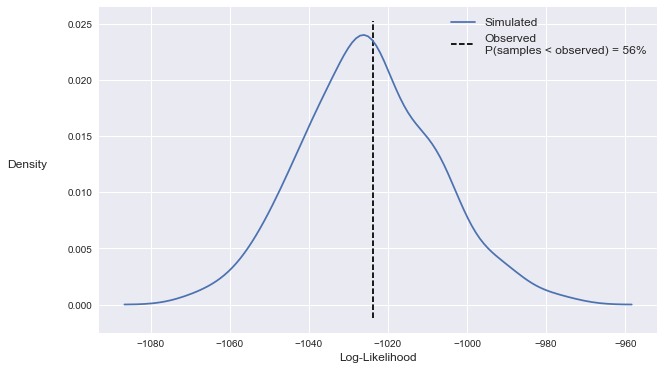

In [22]:
# Generate the simulated log-likelihoods
sim_log_likes =\
    viz.compute_prior_predictive_log_likelihoods(
        model_checker.sim_y,
        clean_df,
        choice_col,
        model_checker.model)

# Plot the simulated versus observed log-likelihood
log_like_path = None
viz.plot_predicted_log_likelihoods(sim_log_likes,
                                   model_checker.model.llf,
                                   output_file=log_like_path)

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


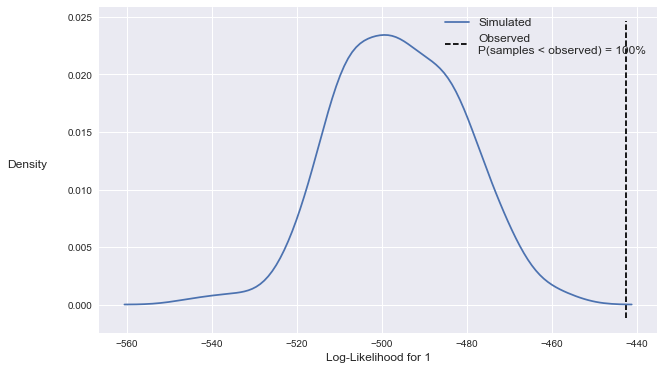

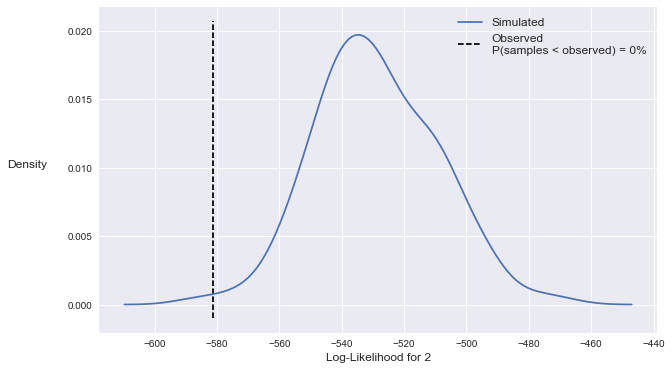

In [23]:
# Plot the simulated versus observed log-likelihood for each
# alternative
log_like_path = None
for alt_id in np.sort(clean_df[alt_id_col].unique()):
    alt_idx = clean_df[alt_id_col] == alt_id

    current_sim_y = model_checker.sim_y[alt_idx, :]
    current_obs_y = model_checker.model.choices[alt_idx]

    current_probs =\
        model_checker.model.long_fitted_probs[alt_idx]

    current_sim_log_likes =\
        current_sim_y.T.dot(np.log(current_probs))

    current_log_likelihood =\
        current_obs_y.dot(np.log(current_probs))

    current_alt_label = alt_id_reverse_map[alt_id]

    current_x_label =\
        'Log-Likelihood for {}'.format(current_alt_label)

    viz.plot_predicted_log_likelihoods(current_sim_log_likes,
                                       current_log_likelihood,
                                       x_label=current_x_label,
                                       output_file=log_like_path)

### 2. Outcome Boxplot

Unique x-values: 100%|██████████| 2/2 [00:00<00:00, 243.75it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


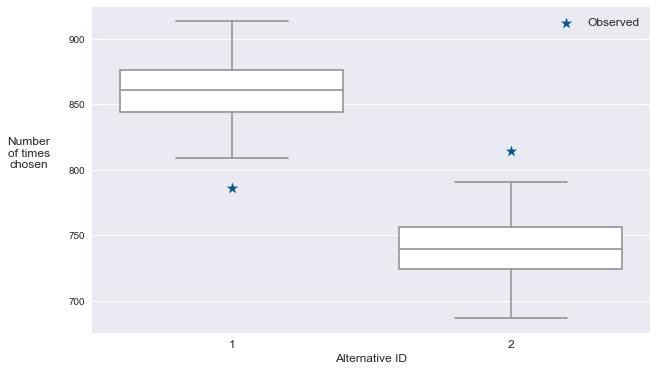

In [24]:
market_path = None
num_obs = model_checker.model.nobs


viz.plot_simulated_market_shares(
    clean_df[alt_id_col].values,
    model_checker.sim_y,
    model_checker.model.choices,
    x_label='Alternative ID',
    y_label='Number\nof times\nchosen',
    output_file=market_path)

### 3. Binned Reliability Plot

Plotting: 100%|██████████| 1/1 [00:00<00:00, 111.23it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Plotting: 100%|██████████| 1/1 [00:00<00:00, 307.41it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


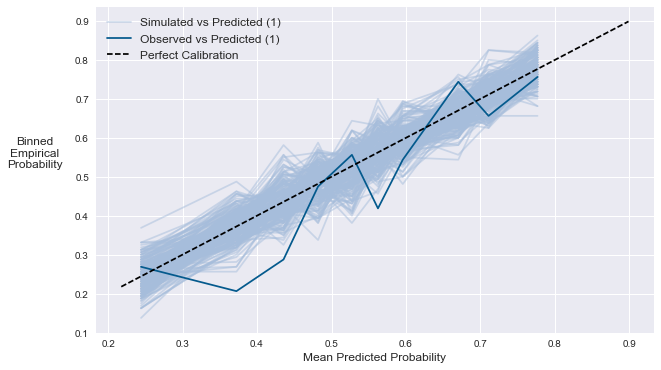

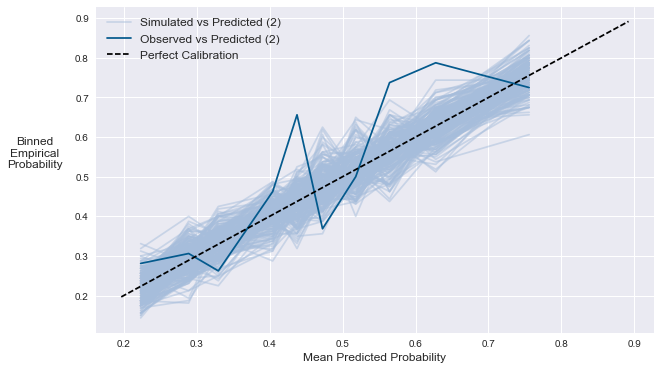

In [25]:
reload(viz)
for alt in np.sort(np.unique(model_checker.model.alt_IDs)):
    
    current_filter = model_checker.model.alt_IDs == alt
    current_probs =\
        model_checker.model.long_fitted_probs[current_filter]
    current_choices =\
        model_checker.model.choices[current_filter]
    current_sim_y = model_checker.sim_y[current_filter, :]
    
    current_alt = alt_id_reverse_map[alt]
    current_line_label =\
        'Observed vs Predicted ({})'.format(current_alt)
    current_sim_label =\
        'Simulated vs Predicted ({})'.format(current_alt)

    current_sim_color = '#a6bddb'
    current_obs_color = '#045a8d'

    viz.plot_binned_reliability(
        current_probs,
        current_choices,
        sim_y=current_sim_y,
        line_label=current_line_label,
        line_color=current_obs_color,
        sim_label=current_sim_label,
        sim_line_color=current_sim_color,
        figsize=(10, 6),
        ref_line=True,
        output_file=None)

### 4. 'Bagged' Reliability Plot

Plotting: 100%|██████████| 200/200 [00:31<00:00,  6.60it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Plotting: 100%|██████████| 200/200 [00:30<00:00,  6.58it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a

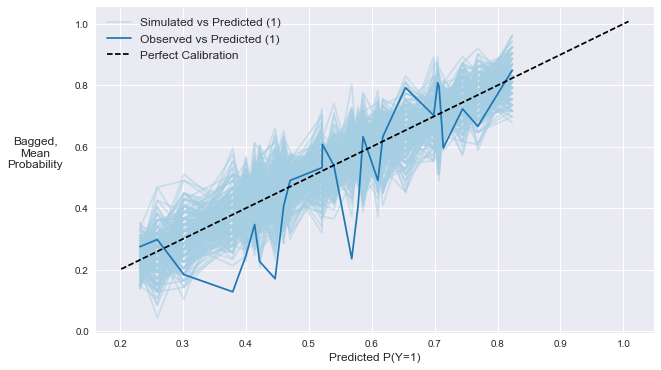

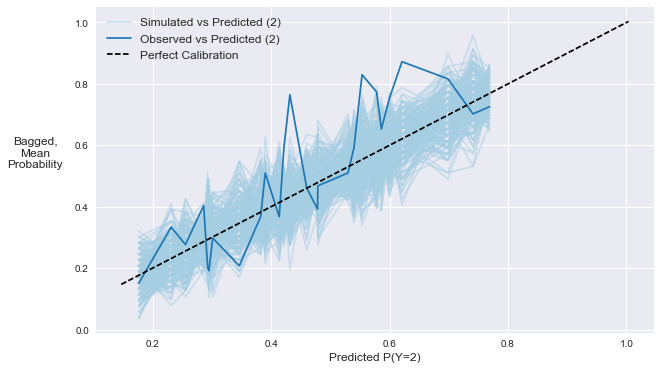

In [26]:
for alt in np.sort(np.unique(model_checker.model.alt_IDs)):
    current_filter = model_checker.model.alt_IDs == alt
    current_probs =\
        model_checker.model.long_fitted_probs[current_filter]
    current_choices =\
        model_checker.model.choices[current_filter]
    current_sim_y = model_checker.sim_y[current_filter, :]
    
    current_alt = alt_id_reverse_map[alt]
    current_line_label =\
        'Observed vs Predicted ({})'.format(current_alt)
    current_sim_label =\
        'Simulated vs Predicted ({})'.format(current_alt)

    filename = None

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
    fig_and_ax = [fig, ax]
    viz.make_bagged_marginal_model_plot(
        current_sim_y,
        current_choices,
        current_probs,
        y_label=current_line_label,
        prob_label=current_sim_label,
        x_label='Predicted P(Y={})'.format(current_alt),
        alpha=0.5,
        fig_and_ax=fig_and_ax,
        output_file=filename)

    # Determine the maximum value of the x-axis or y-axis
    max_ref_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
    min_ref_val = max(ax.get_xlim()[0], ax.get_ylim()[0])
    # Determine the values to use to plot the reference line
    ref_vals = np.linspace(min_ref_val, max_ref_val, num=100)
    # Plot the reference line as a black dashed line
    ax.plot(ref_vals, ref_vals, 'k--', label='Perfect Calibration')
    ax.legend(loc='best', fontsize=12)
    # Show the plot
    fig.show();

### 5. Binned marginal model plots

In [27]:
filename = None
for alt in np.sort(np.unique(model_checker.model.alt_IDs)):
    current_filter = model_checker.model.alt_IDs == alt
    current_probs = model_checker.posterior_probs[current_filter]
    current_choices =\
        model_checker.model.choices[current_filter]
    current_sim_y = model_checker.sim_y[current_filter, :]
    
    current_alt = alt_id_reverse_map[alt]
    current_line_label =\
        'Observed P(Y={})'.format(current_alt)
    current_sim_label =\
        'Simulated P(Y={})'.format(current_alt)
    current_predicted_label =\
        'Predicted P(Y={})'.format(current_alt)
    for col in continuous_variables:
        current_x = clean_df.loc[current_filter, col].values
    
        viz.make_binned_marginal_model_plot(
            current_probs,
            current_choices,
            current_x,
            partitions=10,
            sim_y=current_sim_y,
            y_label=current_line_label,
            prob_label=current_predicted_label,
            sim_label=current_sim_label,
            x_label=col,
            alpha=0.5,
            figsize=(10, 6),
            output_file=filename)

### 6. Bagged marginal model plots

#### 6a. Check the relationships with the raw explanatory variables

In [28]:
filename = None
for alt in np.sort(np.unique(model_checker.model.alt_IDs)):
    current_filter = model_checker.model.alt_IDs == alt
    current_probs = model_checker.posterior_probs[current_filter]
    current_choices =\
        model_checker.model.choices[current_filter]
    current_sim_y = model_checker.sim_y[current_filter, :]
    
    current_alt = alt_id_reverse_map[alt]
    current_line_label =\
        'Observed P(Y={})'.format(current_alt)
    current_sim_label =\
        'Simulated P(Y={})'.format(current_alt)
    current_predicted_label =\
        'Predicted P(Y={})'.format(current_alt)
    for col in continuous_variables:
        current_x = clean_df.loc[current_filter, col].values

        viz.make_bagged_marginal_model_plot(
            current_probs,
            current_choices,
            current_x,
            sim_y=current_sim_y,
            y_label=current_line_label,
            prob_label=current_predicted_label,
            sim_label=current_sim_label,
            x_label=col,
            alpha=0.5,
            figsize=(10, 6),
            output_file=filename)

#### 6b. Check the relationship with the estimated index, $V = X \beta$

Plotting: 100%|██████████| 200/200 [00:27<00:00,  7.45it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Plotting: 100%|██████████| 200/200 [00:29<00:00,  6.39it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


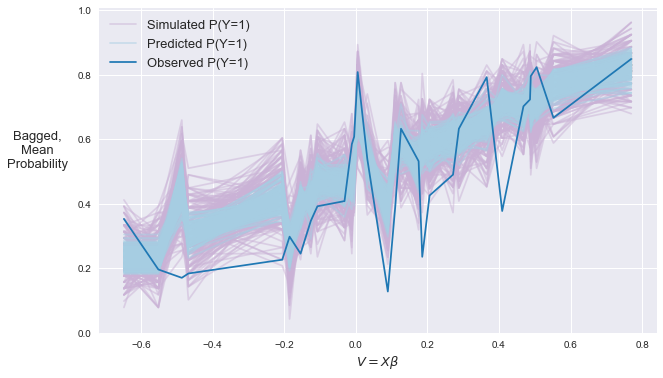

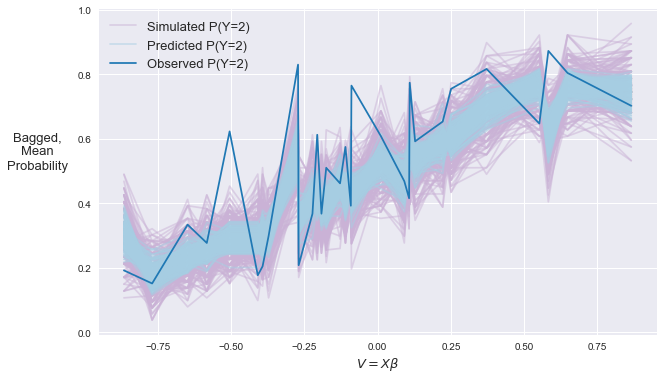

In [29]:
filename = None
for alt in np.sort(np.unique(model_checker.model.alt_IDs)):
    
    current_filter = model_checker.model.alt_IDs == alt
    current_probs = model_checker.posterior_probs[current_filter]
    current_choices =\
        model_checker.model.choices[current_filter]
    current_sim_y = model_checker.sim_y[current_filter, :]
    
    current_alt = alt_id_reverse_map[alt]
    current_x =\
        model_checker.model.design.dot(
         model_checker.model.params)[current_filter]
        
    current_y_label = 'Observed P(Y={})'.format(current_alt)
    current_prob_label = 'Predicted P(Y={})'.format(current_alt)
    current_sim_label = 'Simulated P(Y={})'.format(current_alt)

    viz.make_bagged_marginal_model_plot(
        current_probs,
        current_choices,
        current_x,
        sim_y=current_sim_y,
        y_label=current_y_label,
        prob_label=current_prob_label,
        sim_label=current_sim_label,
        x_label=r'$V = X \beta$',
        alpha=0.5,
        figsize=(10, 6),
        fontsize=13,
        output_file=filename)

### 7. Simulated KDEs

In [30]:
filename = None
for alt in np.sort(np.unique(model_checker.model.alt_IDs)):
    current_filter = model_checker.model.alt_IDs == alt
    current_title = 'Y = {}'.format(alt)

    for col in continuous_variables:
        viz.plot_simulated_kde_traces(
            model_checker.sim_y,
            clean_df,
            current_filter,
            col,
            choice_col,
            label='Simulated {}'.format(col),
            title=current_title,
            figsize=(10, 6),
            output_file=filename)

### 8. Simulated CDFs

In [31]:
filename = None
for alt in np.sort(np.unique(model_checker.model.alt_IDs)):
    current_filter = model_checker.model.alt_IDs == alt
    current_title = 'Y = {}'.format(alt)

    for current_col in continuous_variables:
        viz.plot_simulated_cdf_traces(
            iteraction_checker.sim_y,
            clean_df,
            current_filter,
            current_col,
            choice_col,
            label='Simulated ({})'.format(col),
            title=current_title,
            figsize=(10, 6),
            output_file=filename)

### 9. Simulated Histograms

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matp

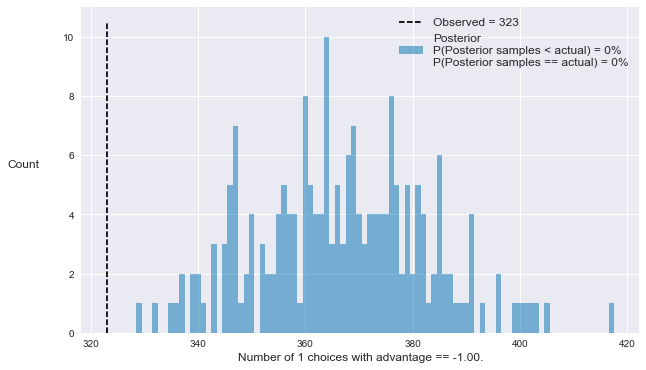

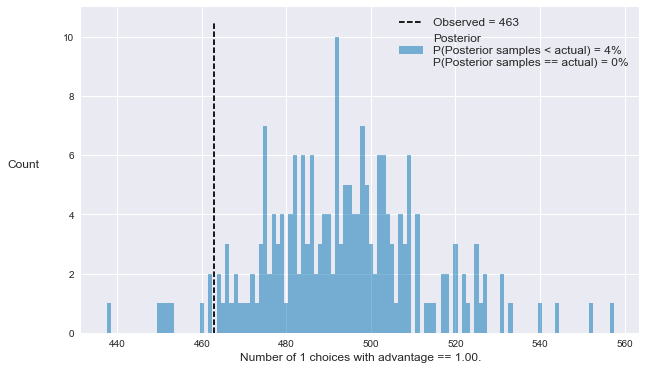

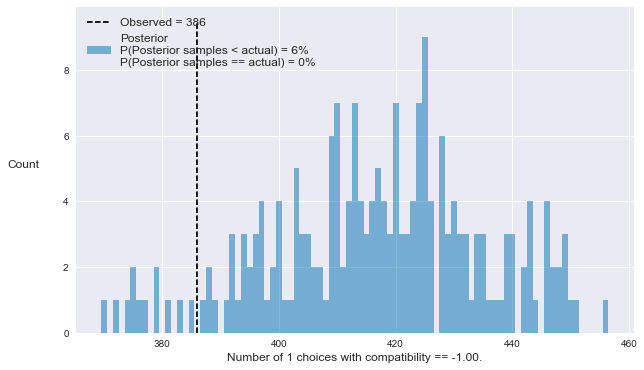

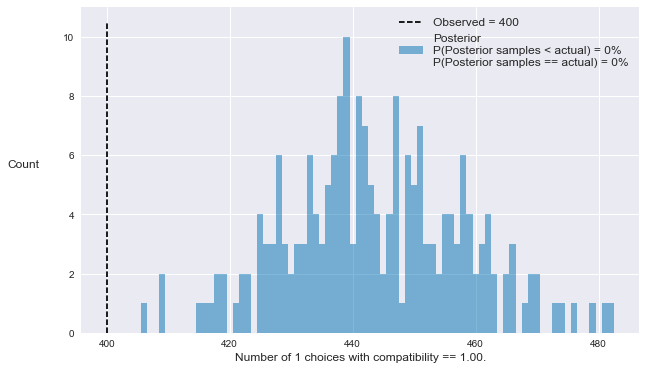

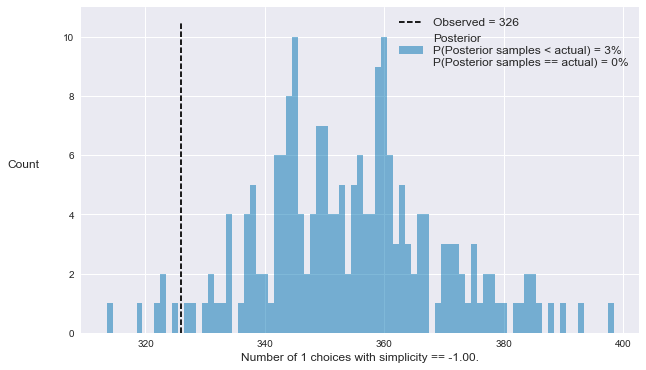

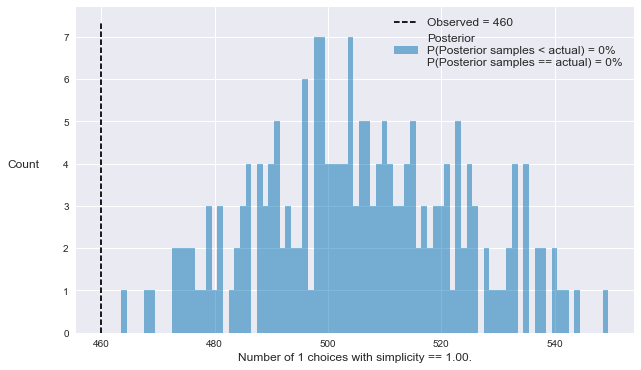

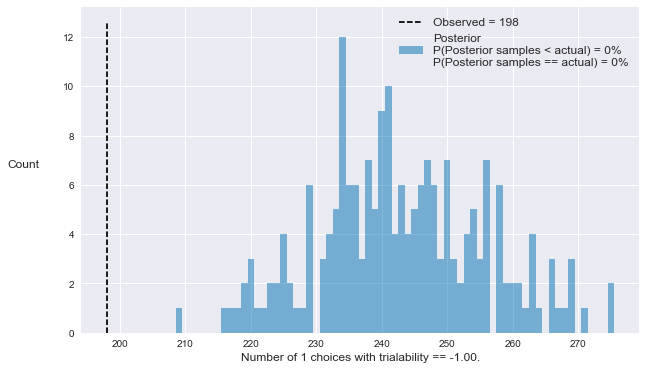

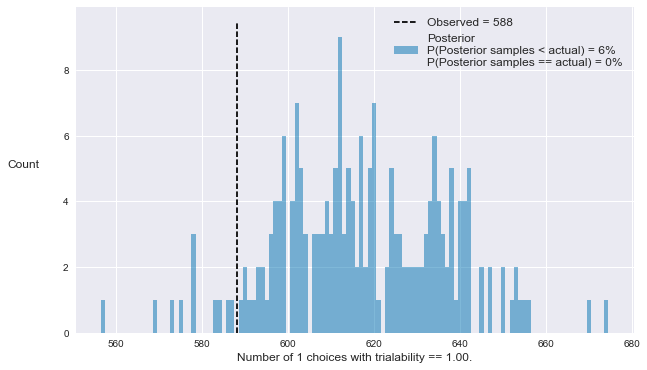

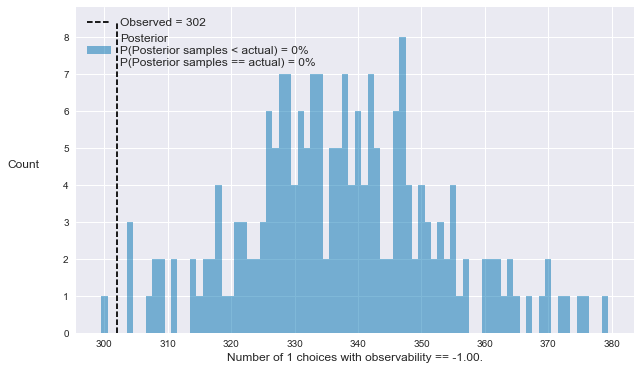

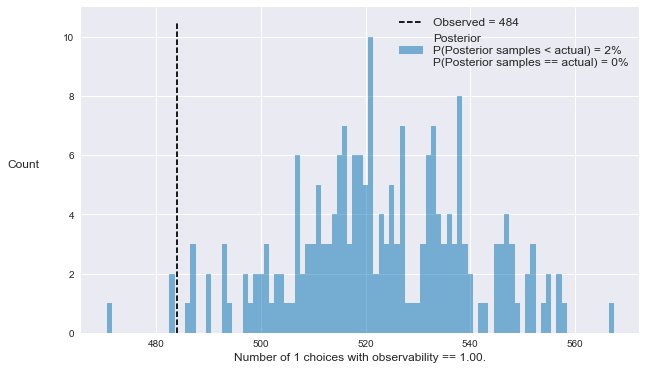

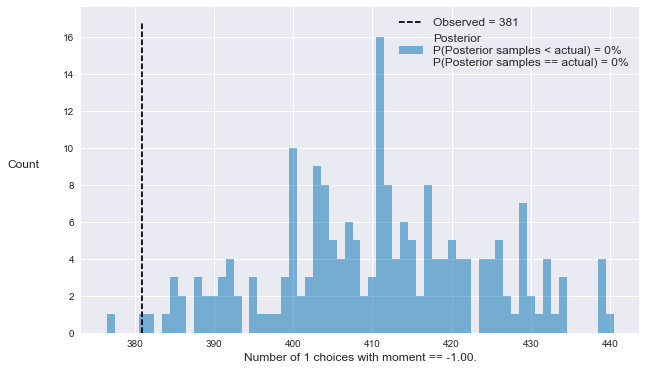

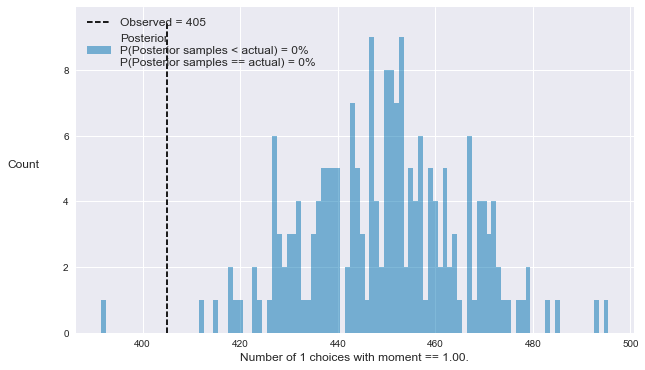

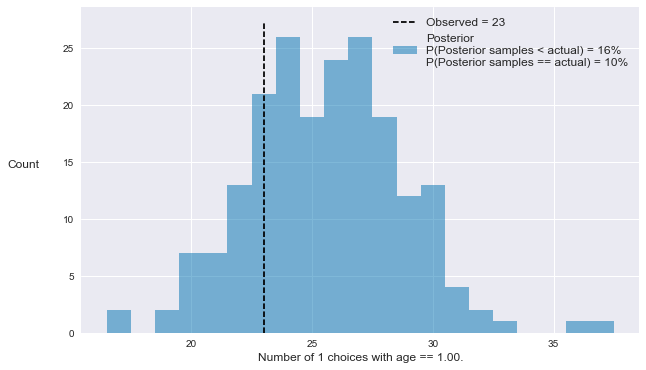

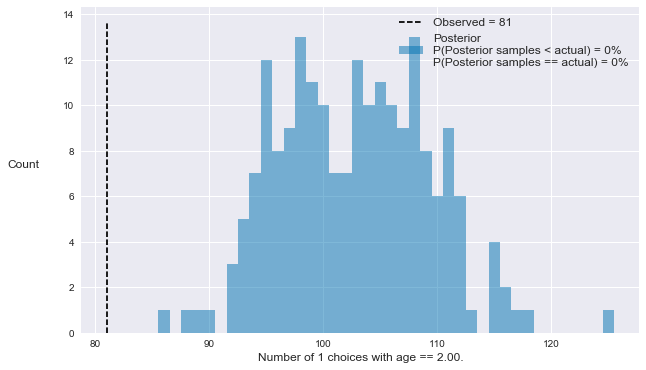

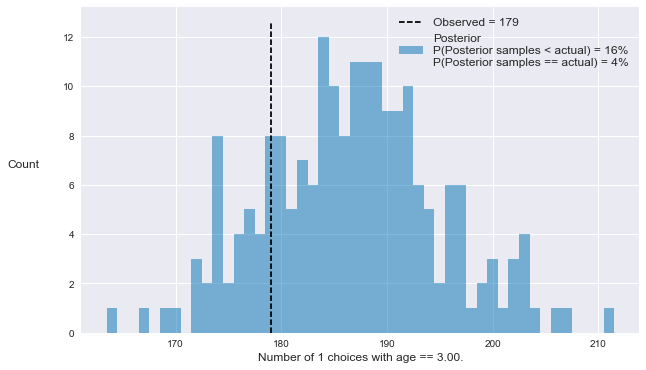

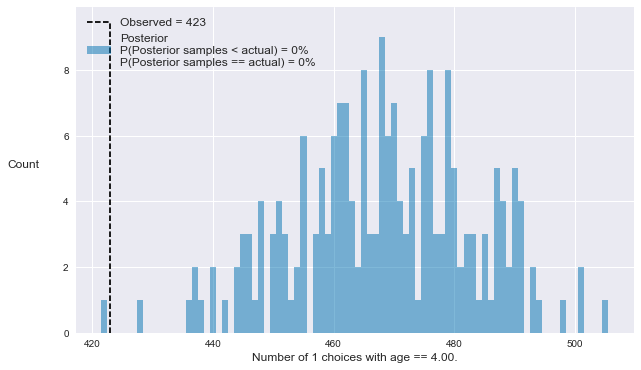

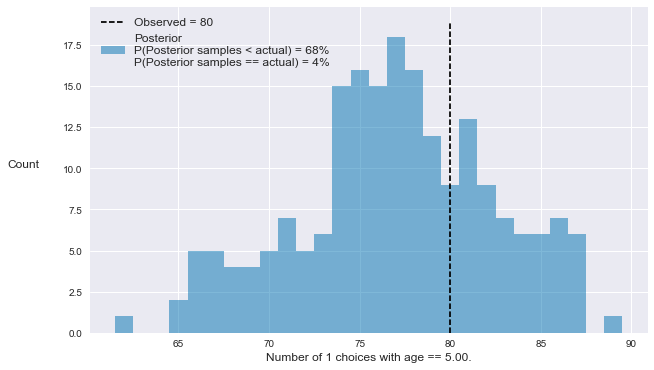

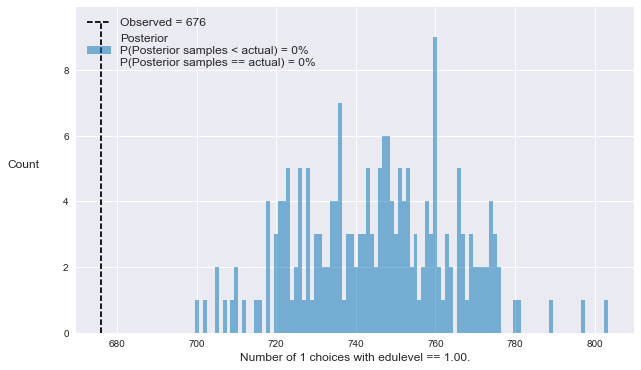

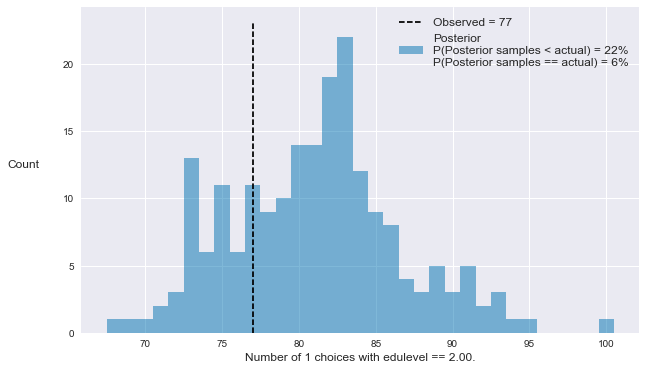

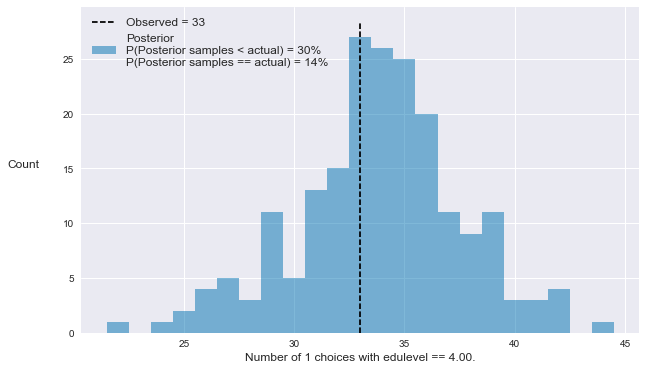

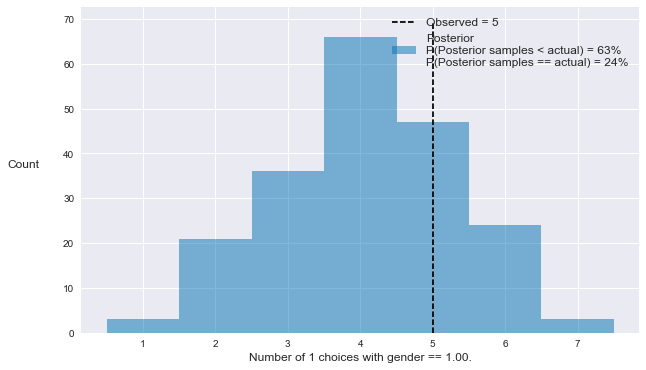

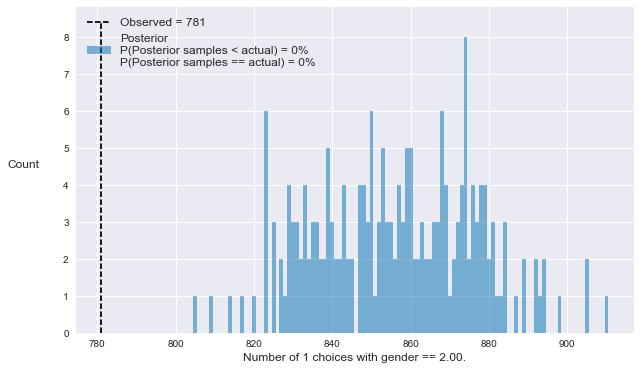

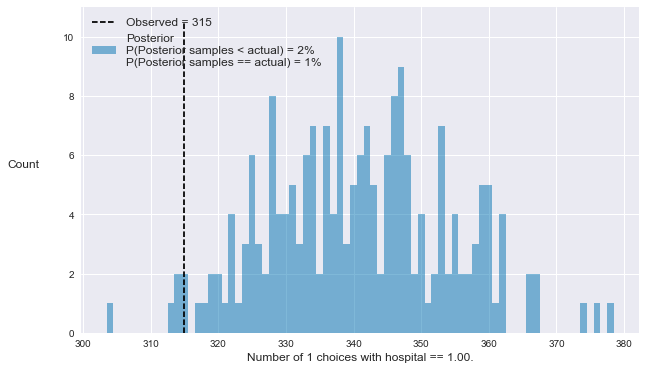

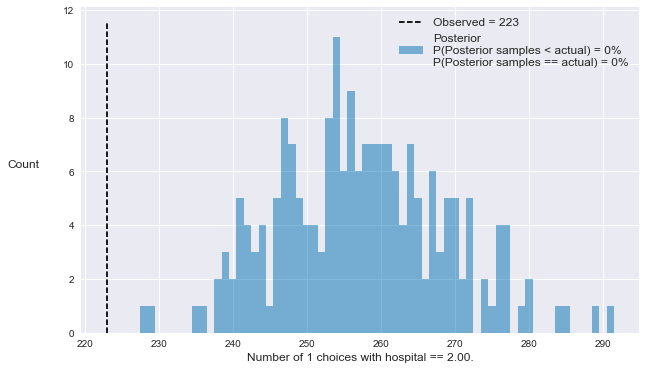

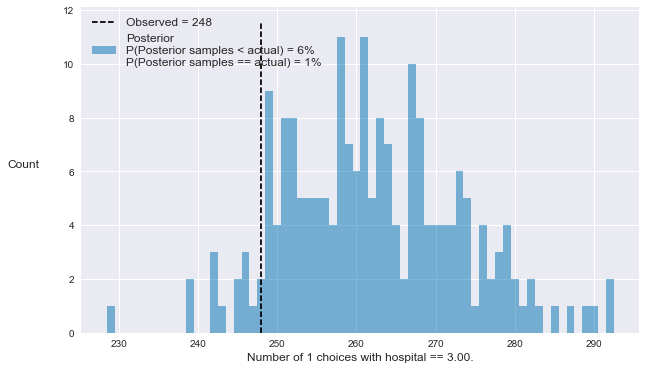

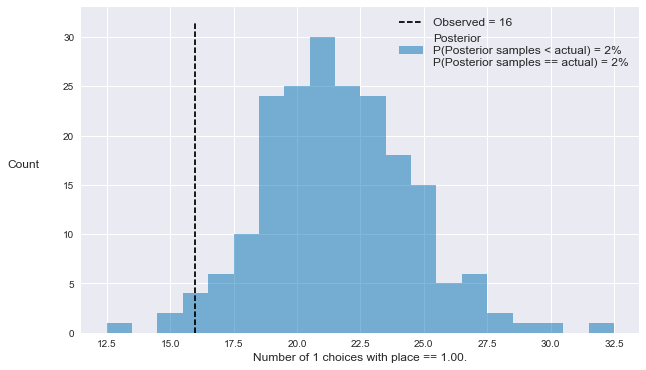

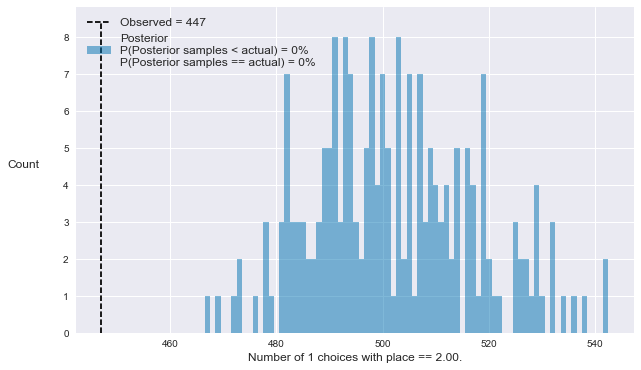

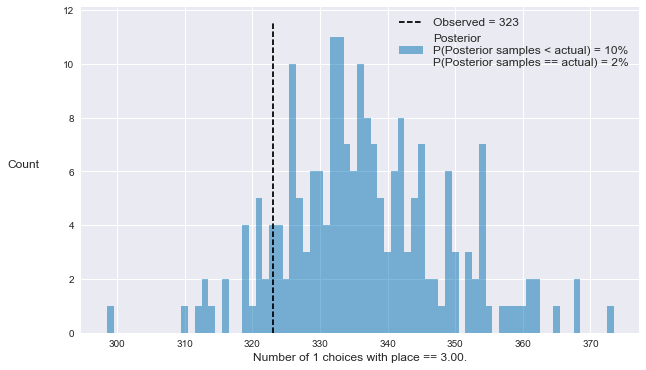

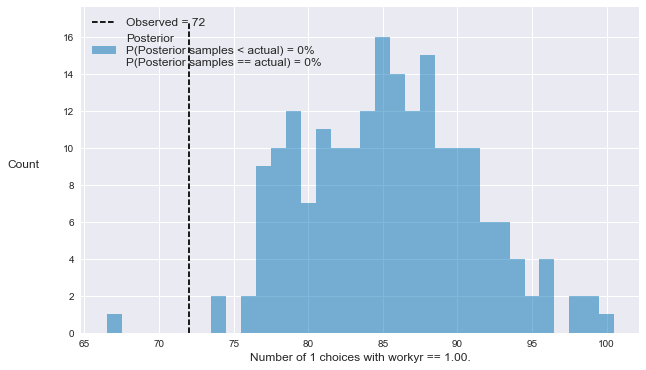

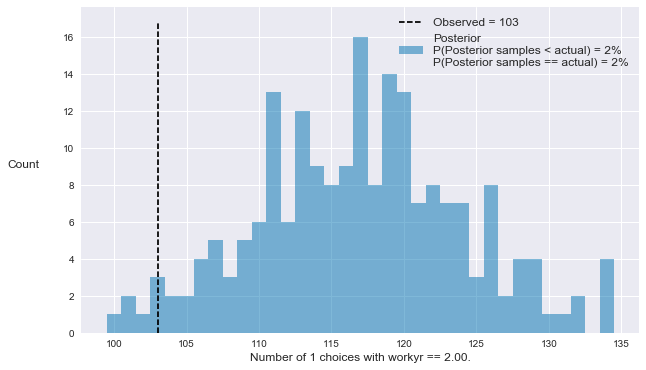

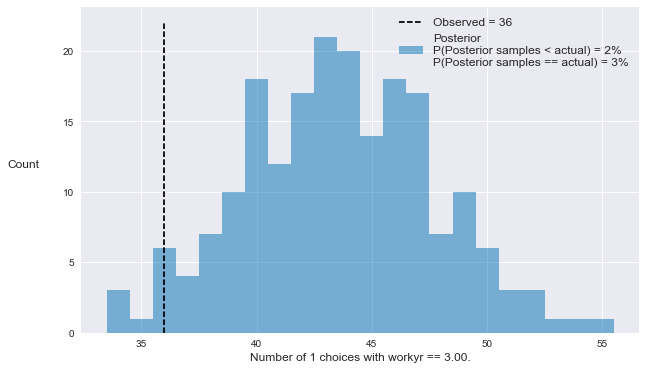

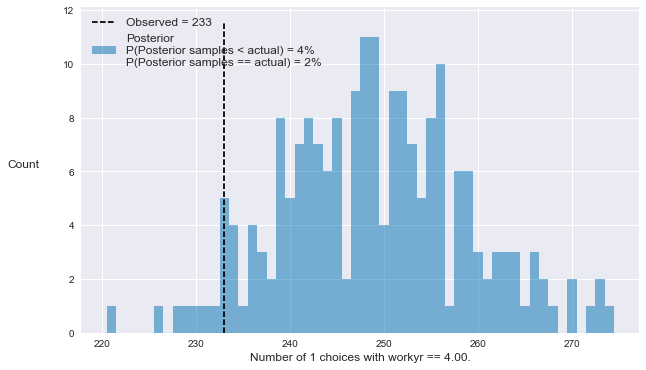

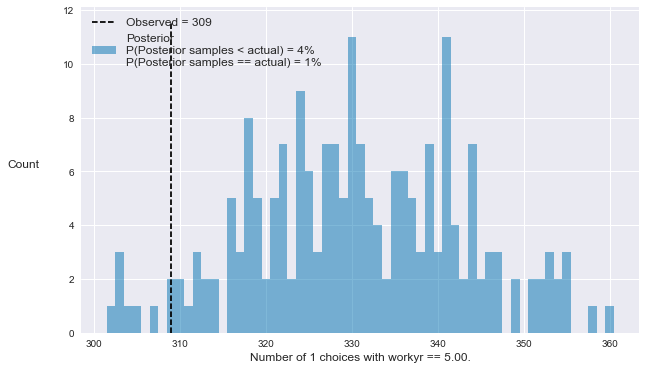

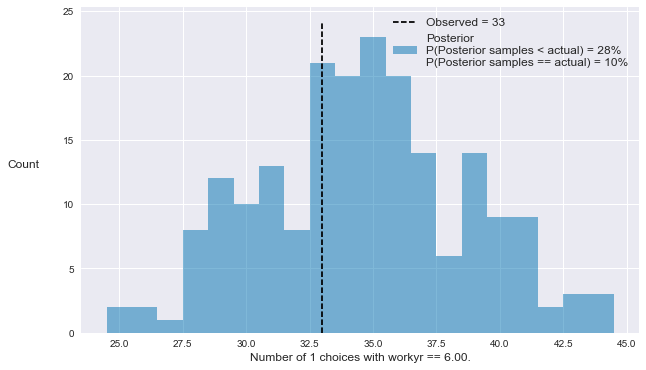

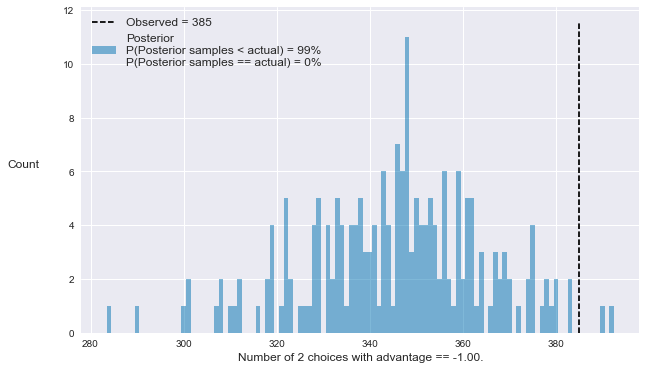

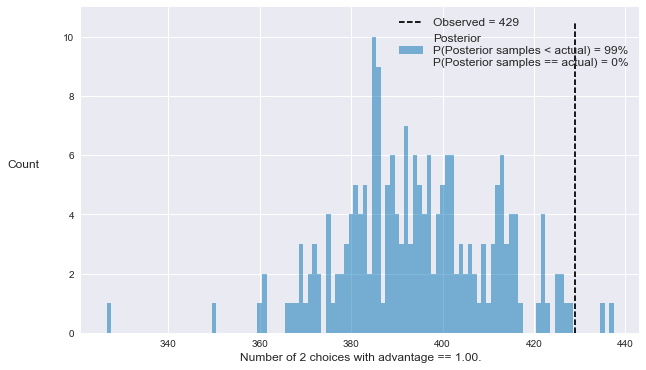

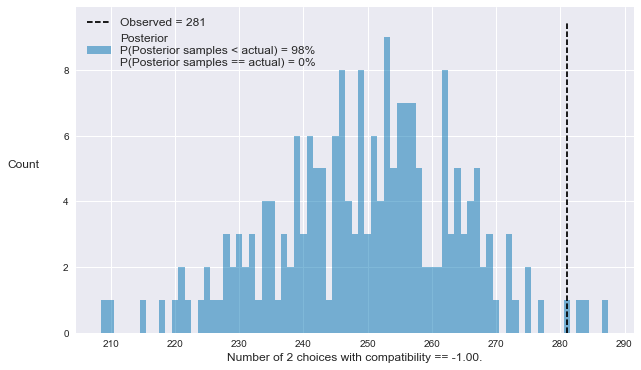

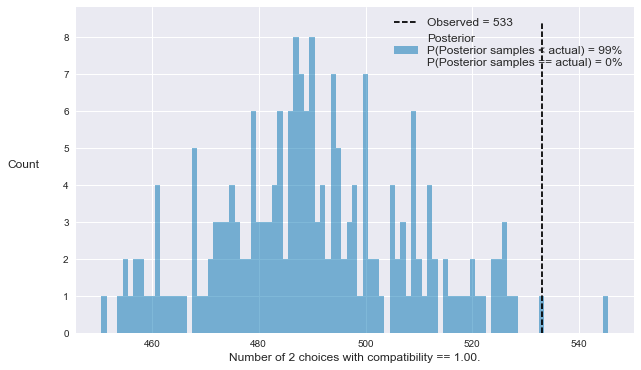

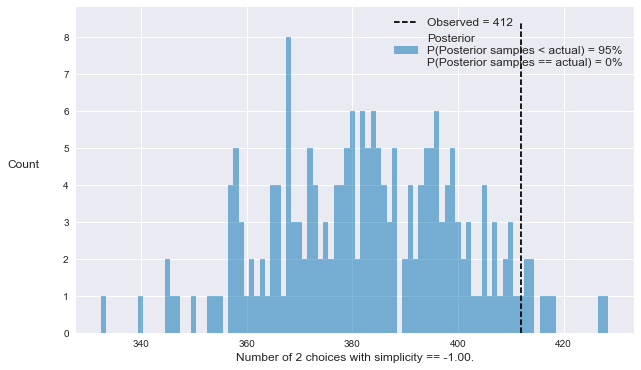

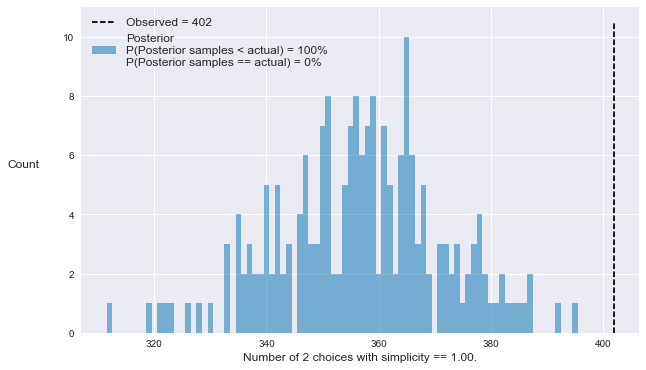

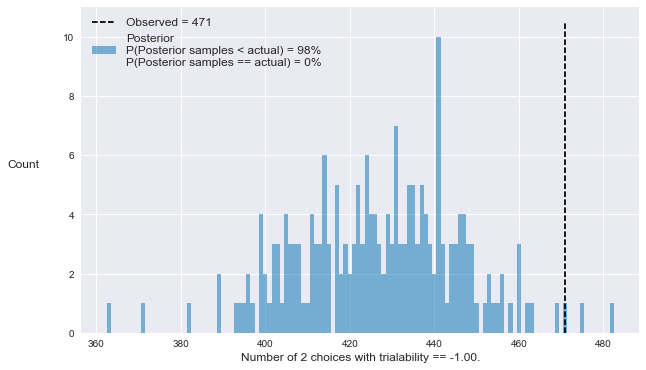

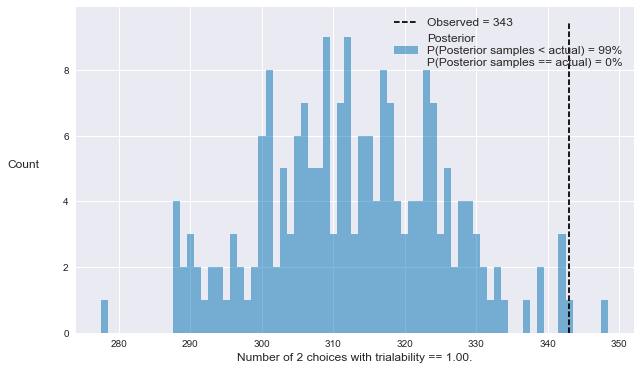

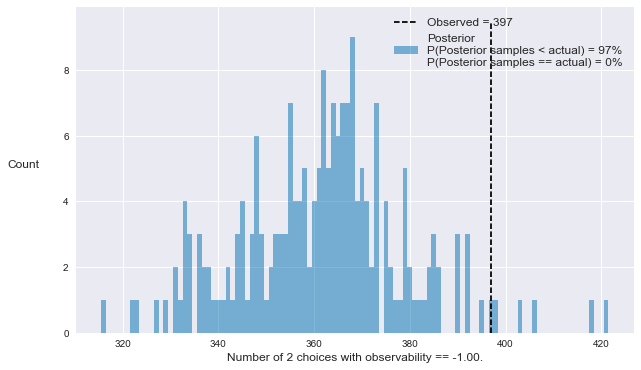

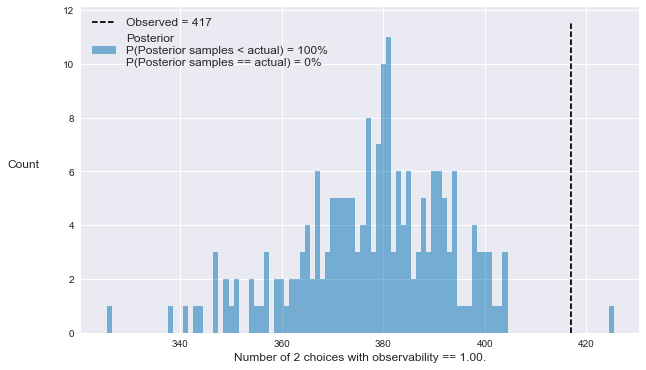

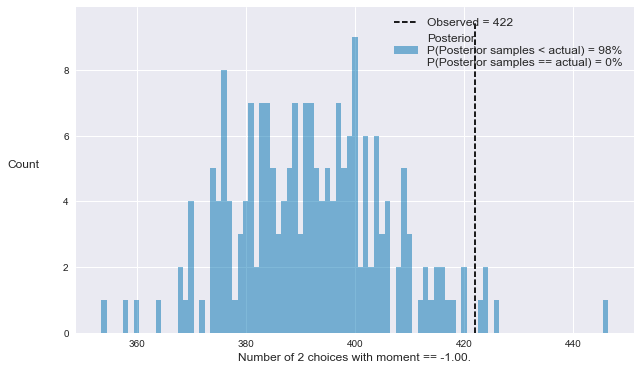

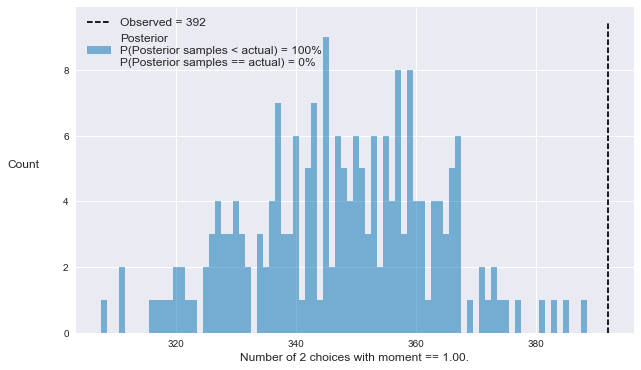

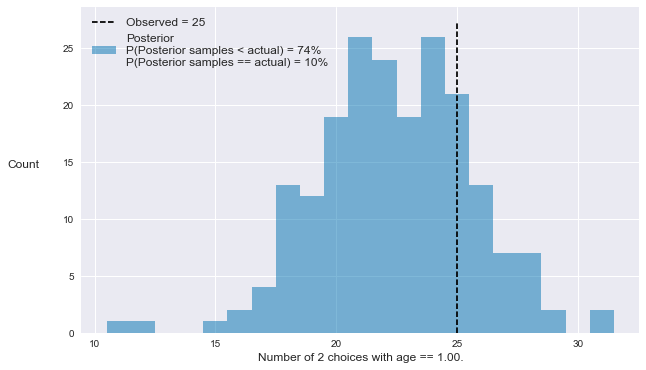

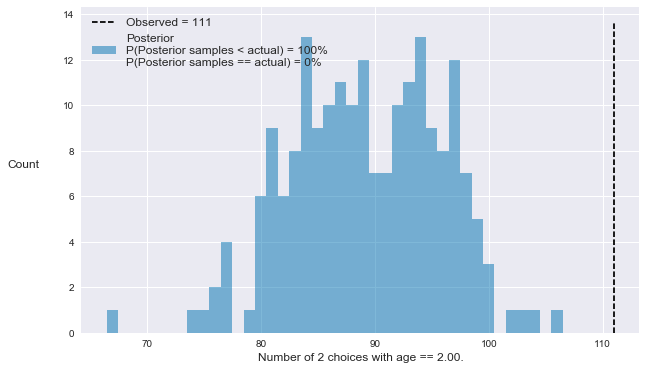

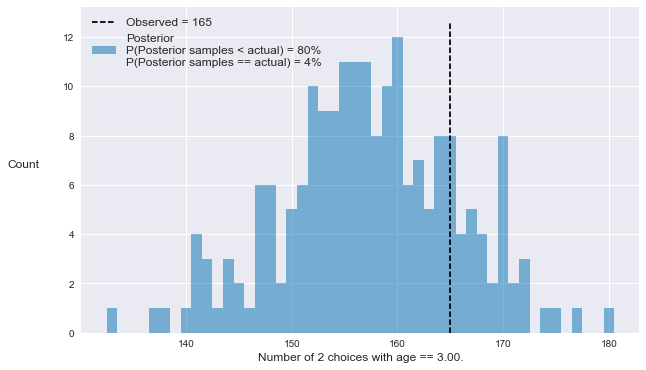

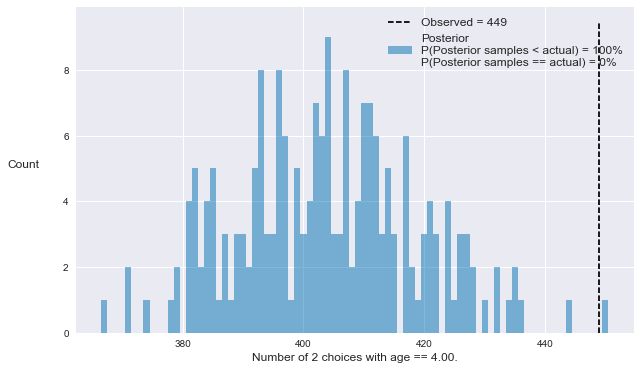

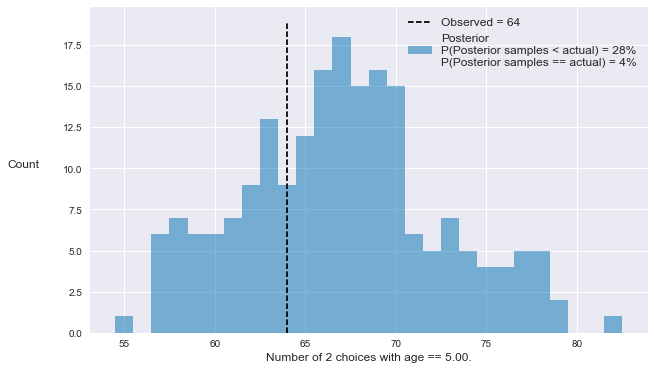

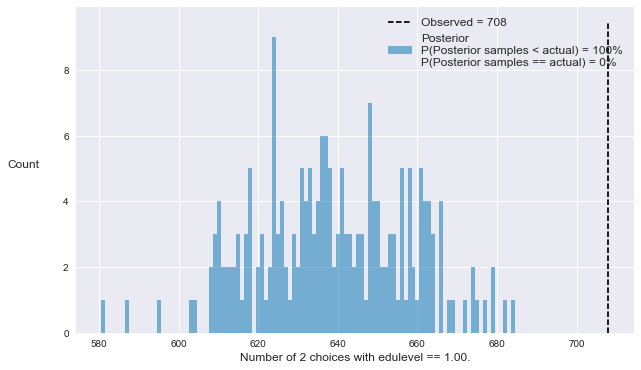

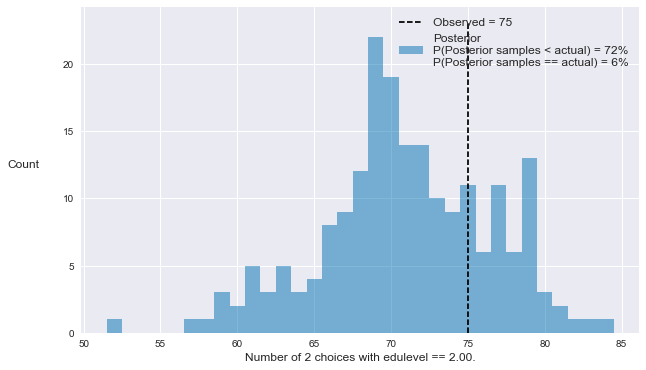

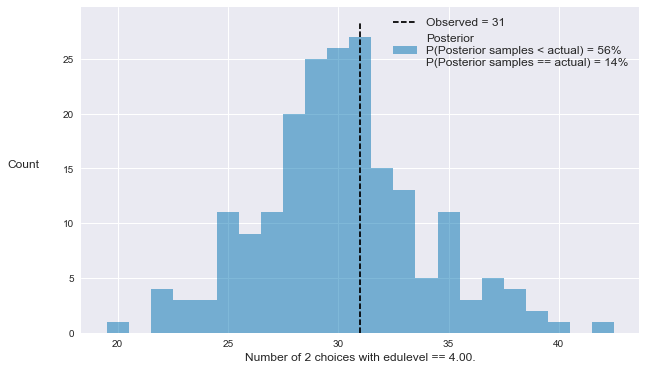

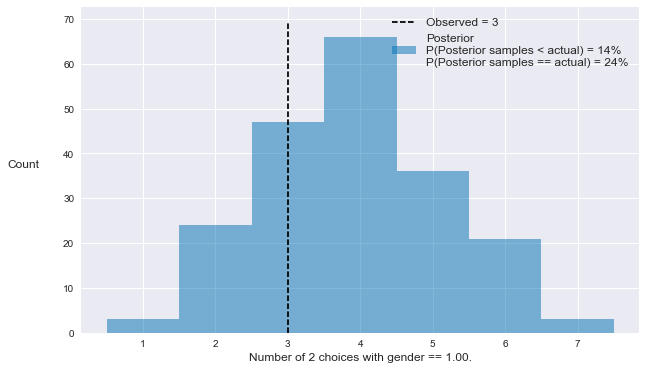

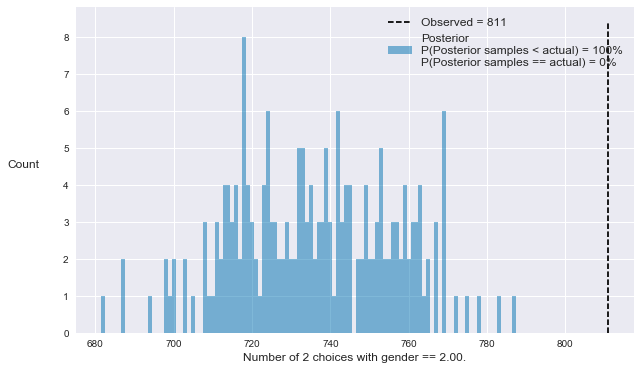

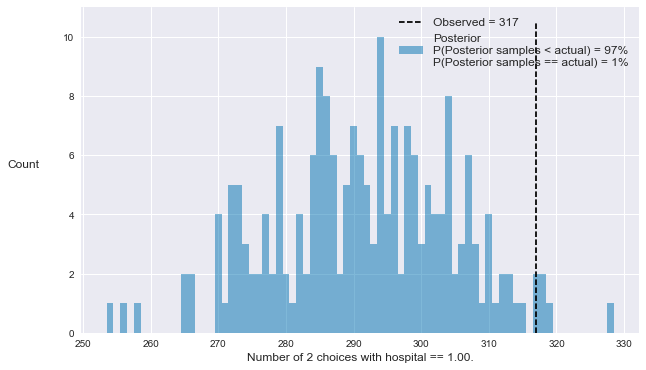

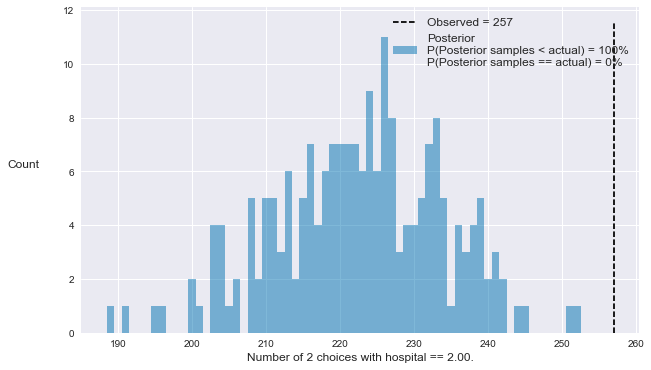

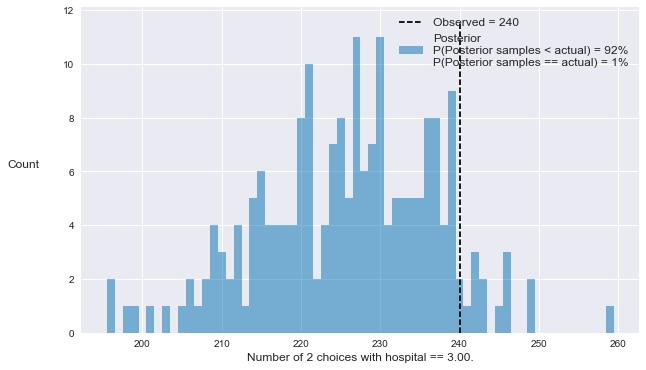

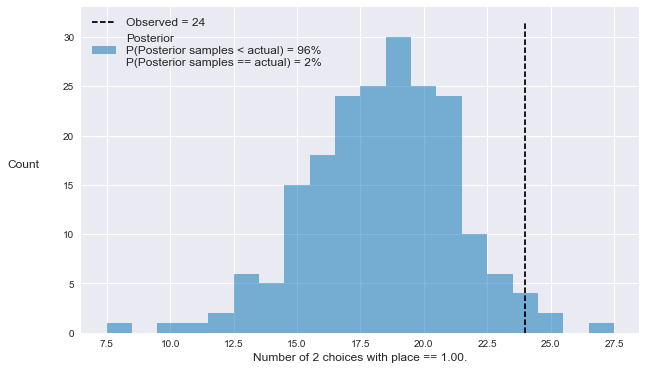

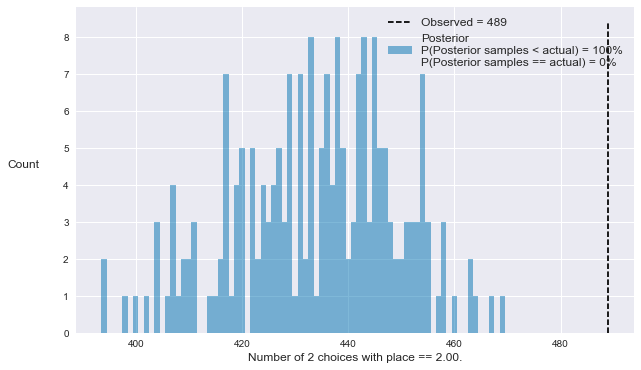

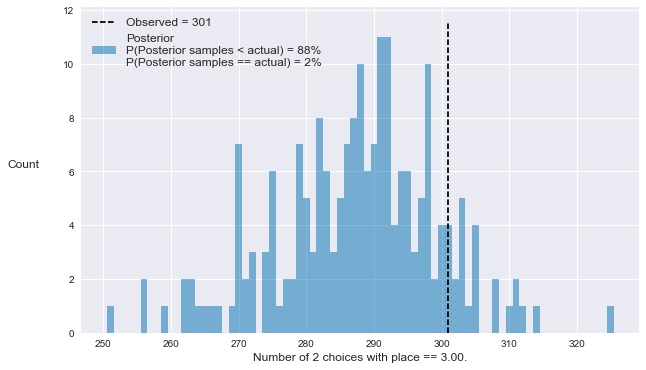

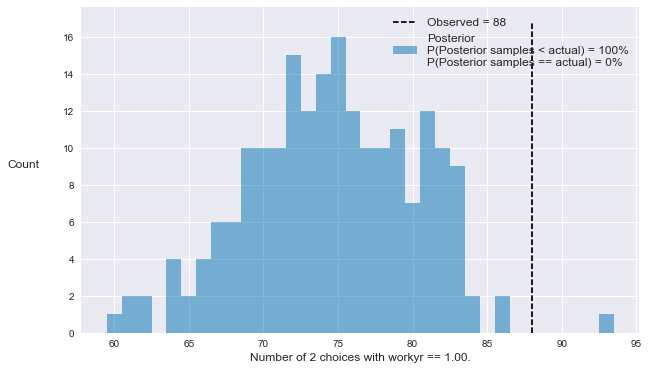

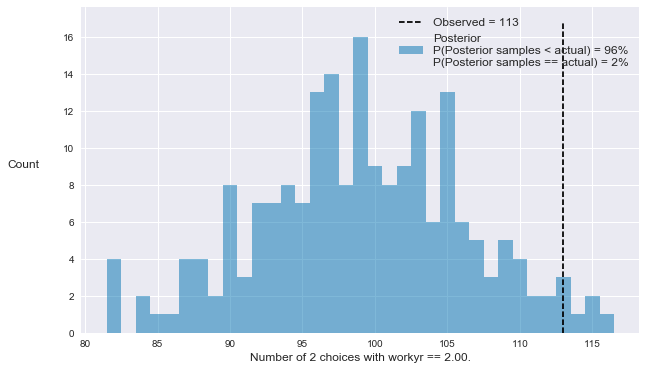

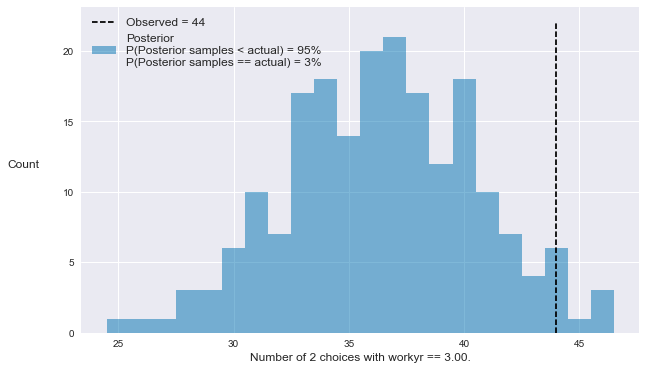

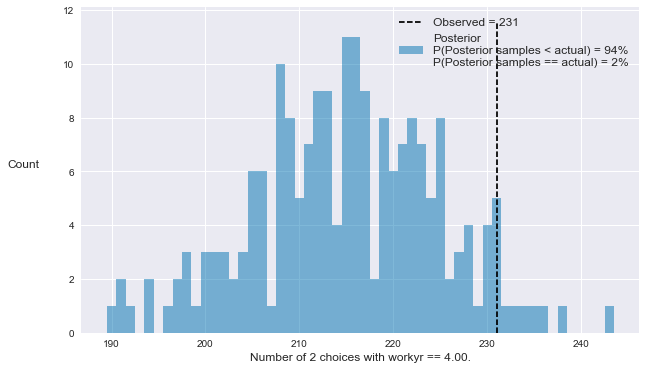

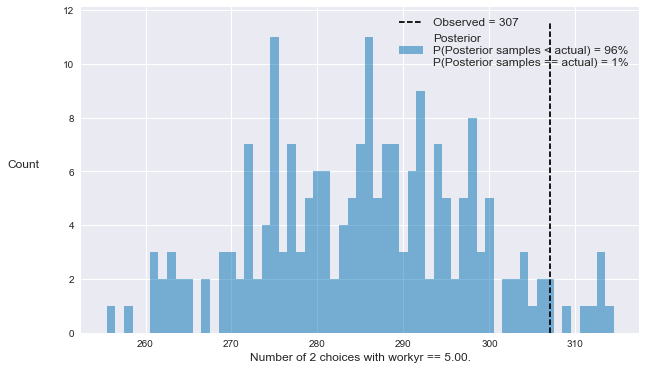

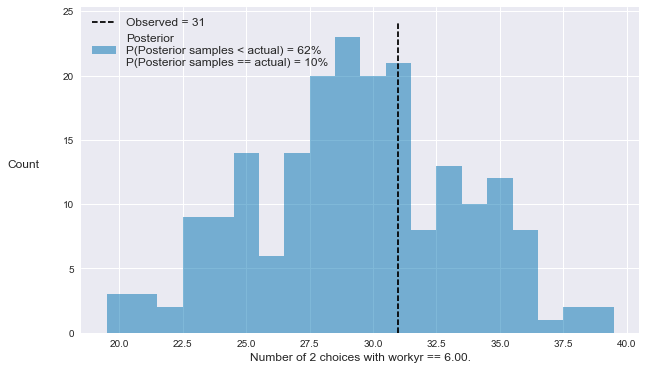

In [32]:
filename = None
for alt in np.sort(np.unique(model_checker.model.alt_IDs)):
    current_filter = model_checker.model.alt_IDs == alt
    alt_name = alt_id_reverse_map[alt]
    current_filter_name = '{} choices'.format(alt_name)
    current_title = ''

    for current_col in categorical_variables:
        viz.plot_categorical_predictive_densities(
            clean_df,
            None,
            model_checker.sim_y,
            current_col,
            current_filter,
            model_checker.model.choices.astype(int),
            title=current_title,
            filter_name=current_filter_name,
            post_color=sbn.color_palette('colorblind')[0],
            figsize=(10, 6),
            legend_loc='best',
            output_file=filename)

###  10. Simulated Lagrange Multiplier tests for mixing

### Generate artificial variables for Lagrange Multiplier Checks
Note that this is based on the Lagrange Multiplier tests described in McFadden, D., Train, K., 2000. Mixed MNL Models for Discrete Response. Journal of Applied Econometrics 15, 447–470.

In [33]:
# Get the rows_to_obs matrix
rows_to_obs = model_obj.get_mappings_for_fit()['rows_to_obs']

# Get the mean attribute values for each observation
probs_to_obs = rows_to_obs.multiply(model_obj.long_fitted_probs[:, None])

# Will have shape (num_obs, design[1])
x_mean_per_obs = probs_to_obs.T.dot(model_obj.design)

# Will have same shape as the design matrix
long_x_mean_per_obs = rows_to_obs.dot(x_mean_per_obs)

# X - X_mean_per_obs
augmented_x = model_obj.design - long_x_mean_per_obs

# z = 0.5 * (x - x_bar)^2
artificial_x = 0.5 * augmented_x**2

### Make the desired plots

Plotting: 100%|██████████| 200/200 [00:26<00:00,  7.37it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Plotting: 100%|██████████| 200/200 [00:27<00:00,  7.28it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Plotting: 100%|██████████| 200/200 [00:27<00:00,  7.26it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Plotting: 100%|██████████| 200/200 [00:27<00:00,  7.15it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: Us

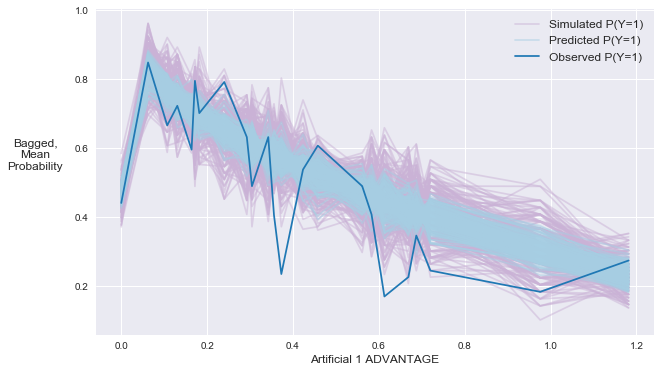

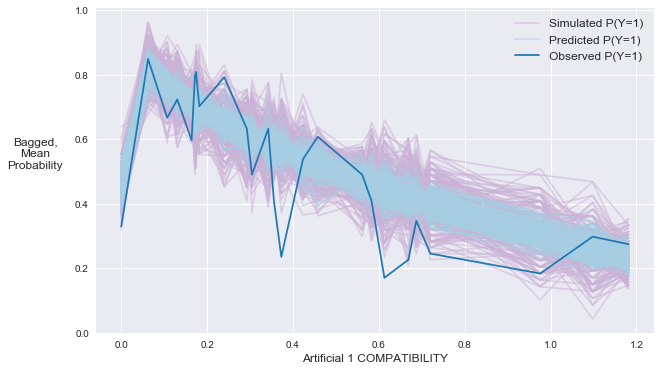

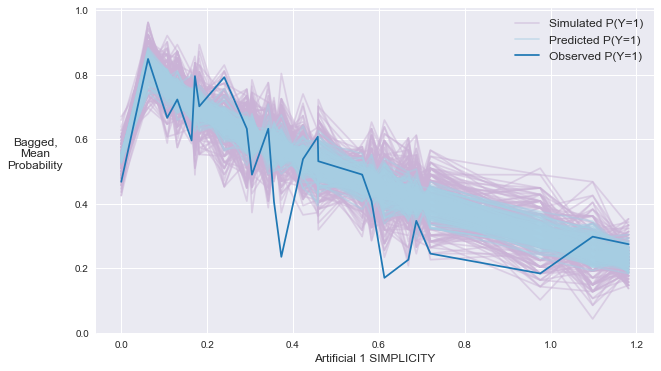

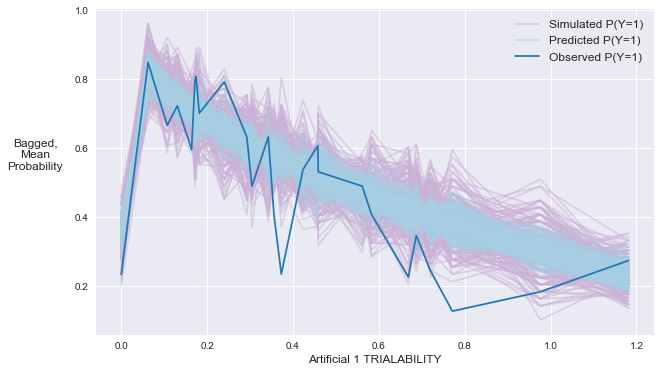

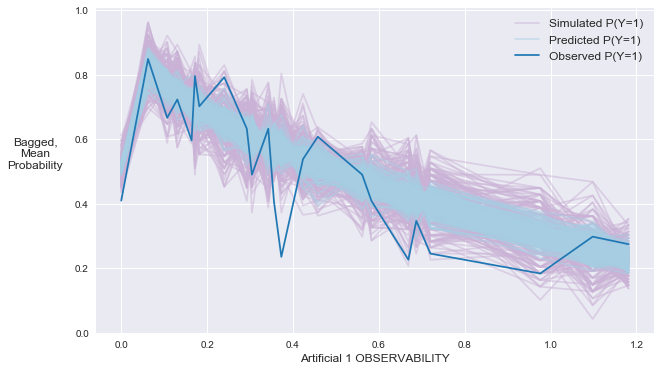

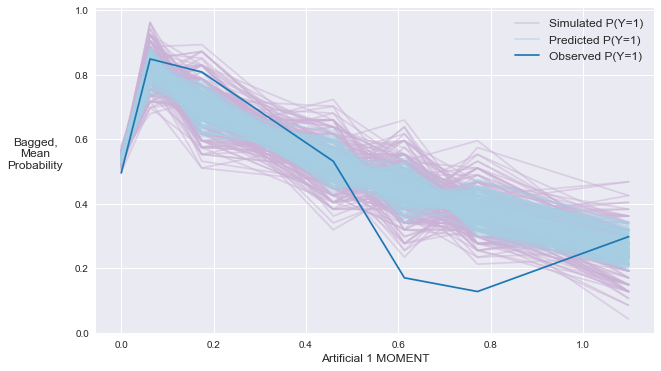

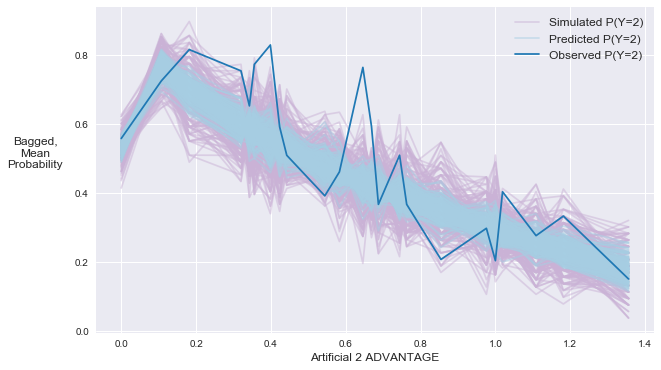

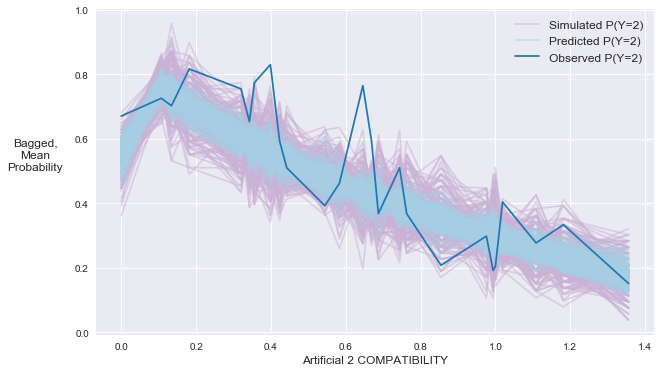

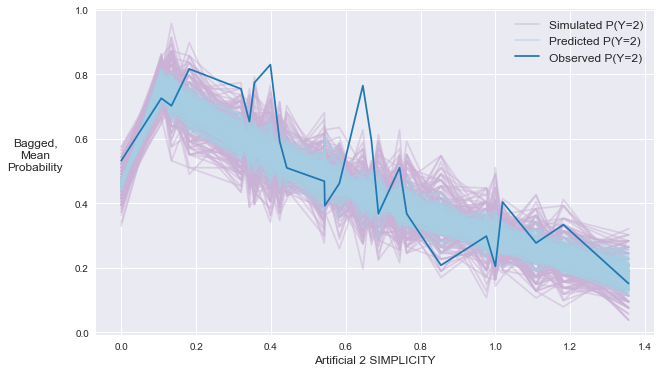

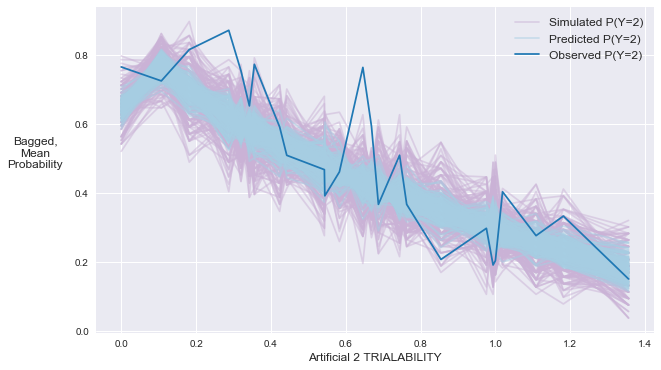

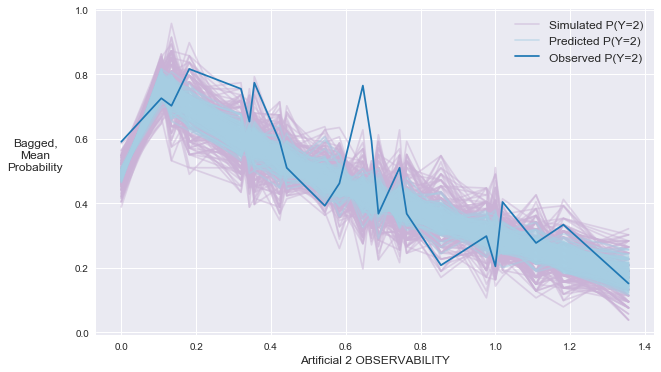

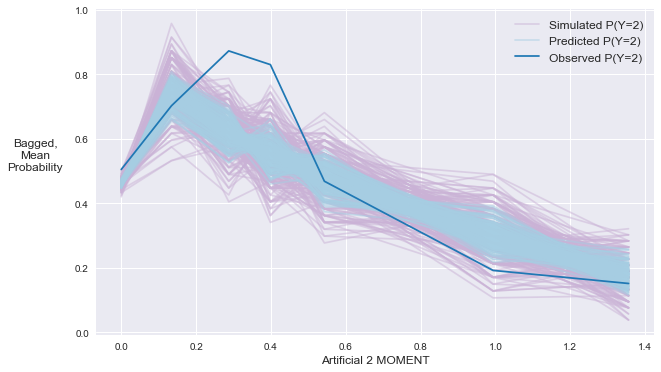

In [34]:
filename = None
for alt in np.sort(np.unique(model_checker.model.alt_IDs)):
    current_filter = model_checker.model.alt_IDs == alt
    alt_name = alt_id_reverse_map[alt]
    current_filter_name = '{} choices'.format(alt_name)
    current_title = '' 

    current_probs =\
        model_checker.posterior_probs[current_filter]
    current_choices =\
        model_checker.model.choices[current_filter]
    current_sim_y = model_checker.sim_y[current_filter, :]
    
    current_y_label = 'Observed P(Y={})'.format(alt_name)
    current_prob_label = 'Predicted P(Y={})'.format(alt_name)
    current_sim_label = 'Simulated P(Y={})'.format(alt_name)
    
    for col in range(model_checker.model.design.shape[1]):
        column_name = (model_checker.model
                                          .params
                                          .index
                                          .tolist()[col])
        current_x = artificial_x[current_filter, col]
        current_x_label =\
            'Artificial {} {}'.format(alt_name, column_name)


        viz.make_bagged_marginal_model_plot(
            current_probs,
            current_choices,
            current_x,
            sim_y=current_sim_y,
            y_label=current_y_label,
            prob_label=current_prob_label,
            sim_label=current_sim_label,
            x_label=current_x_label,
            alpha=0.5,
            figsize=(10, 6))

# Findings and Recommendations based on the posterior predictive checks

1. The posterior predictive checks indicate great model mis-specification for "Alternative 1" and "Alternative 2". This misfit is reiterated in the various predictive performance plots, the market share plots, the reliability plots, as well as the simulated histograms for these alternatives. Basically, "Alternative 1" is systematically over-predicted and "Alternative 2" is systematically under-predicted.
2. An alternative specific constant is likely needed for "Alternative 1" or "Alternative 2".
3. Based on the Lagrange Multiplier checks, a mixed logit specification may perhaps be necessary for some variables. However, I think this may just be an artifact of having all the predicted probabilities for those two alternatives be systematically over/under-estimated.